In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

import torch.nn.functional as F

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '../sympdee/sympde/viz'))
sys.path.append(os.path.join(os.getcwd(), '..'))

from symlie.model.networks.linear import CalculatedP, LinearP
from sympdee.sympde.viz.general_plots import imshows, plot_vals, simple_imshow, savefig, simple_imshow, imshow
from symlie.misc.utils_results import get_and_check_Ps, plot_seeds_and_Ps
from symlie.data.transforms import Transform
from symlie.model.networks.implicit import LinearImplicit
from symlie.model.setup import load_implicitP_statedict, load_P_pred
from symlie.model.loss import mmd

In [2]:
def plot_2columns(x_plots, x_titles):

    nrows = len(x_plots)
    batch_size = x_plots[0][0].shape[0]

    x_idx = np.random.randint(0, batch_size, 1)[0]
    fig, axs = plt.subplots(nrows, 2, figsize = (6, 1.*nrows), tight_layout = True)
    for i, (x_l, x_r) in enumerate(x_plots):

        for j, (x_lr, color) in enumerate(zip([x_l, x_r], ['tab:blue', 'tab:orange'])):
            xx = x_lr[x_idx]
            ax = axs[i, j]
            ax.plot(xx, 'o-', color = color)
            ax.plot([len(xx)-1, len(xx)], [xx[-1], xx[0]], '--', color=color)
            ax.plot([-1, 0], [xx[-1], xx[0]], '--', color=color)
            ax.set_xticks([])
            ax.set_yticks([0])
            ax.set_title(x_titles[i][j])
    plt.show()

def mmd_loss(x, y, kernel = 'multiscale'):
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    return mmd(x, y, kernel = kernel)

In [3]:
map_kwargs = {
    'data_kwargs': {'grid_size': (1, 7), 'noise_std': 0.5},
    'transform_kwargs': {'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip': False},
    'data_dir': '../data/sine1d'
}

batch_size = 16

size = np.prod(map_kwargs['data_kwargs']['grid_size'])
features = size**2
set_bias = False

In [4]:
x = torch.randn(batch_size, size)

def transform(x):
    return torch.roll(x, 1, 1)

In [5]:


# # P = torch.zeros(features, features)

# P = load_P_pred('40avqgiy')
# P = load_P_pred('temp_runid')

# # P = get_and_check_Ps([1], map_kwargs, use_P_from_noise = True)[0]
# P = 'space_translation'
# P = 'none'

linear_kwargs = {
    'in_features': size,
    'out_features': size,
    'bias': set_bias,
    'train_P': True,
    'train_weights': False
}

batch_size_forward = None
# batch_size_forward = batch_size

# linear = LinearP(P_init = P, **linear_kwargs)
# linear_none = LinearP(P_init = 'none', **linear_kwargs)
# linear.reset_parameters(batch_size=batch_size_forward)
# linear_none.reset_parameters(batch_size=batch_size)
# linear_none.weight = linear.weight

# imshow(linear.P.detach(), l = 0.5)


P_init_statedict = load_implicitP_statedict('temp_runid')
P_init_statedict = load_implicitP_statedict('v24f2hfu')
linear = LinearImplicit(P_init = P_init_statedict, hidden_implicit_layers = [49, 49], **linear_kwargs)
linear.reset_parameters()

# linear_none = LinearP(P_init = 'none', **linear_kwargs)
# linear_none.reset_parameters(batch_size=batch_size)
# linear_none.weight = linear.weight

Setup implicit_P
Loading weights P


In [6]:
x_a = x
out_a = linear(x_a, batch_size=batch_size_forward).detach()
out_a_prime = transform(out_a)

# out_a_tilde = linear_none(x_a, batch_size=batch_size_implicit).detach()
# out_a_prime_tilde = transform(out_a_tilde)

x_b = x
x_b_prime = transform(x_b)
out_b_prime = linear(x_b_prime, batch_size=batch_size_forward).detach()

# out_b_prime_tilde = linear_none(x_b_prime, batch_size=batch_size_implicit).detach()

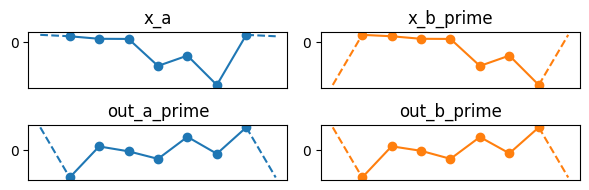

In [7]:
x_plots = [
    [x_a, x_b_prime],
    [out_a_prime, out_b_prime],
]

x_titles = [
    ['x_a', 'x_b_prime'],
    ['out_a_prime', 'out_b_prime'],
]


plot_2columns(x_plots, x_titles)


[[-0.06704674 -0.00498987  0.01138531  0.01635934 -0.00859447 -0.01327092
   0.06556355]
 [ 0.06507033 -0.06703869 -0.00423501  0.01148596  0.01691073 -0.0081828
  -0.01395146]
 [-0.01385803  0.06532363 -0.0669459  -0.00472876  0.01146833  0.01646454
  -0.00908605]
 [-0.00851327 -0.0140529   0.06499124 -0.0674364  -0.00498744  0.0119226
   0.01674441]
 [ 0.0165416  -0.00878771 -0.0135197   0.06481521 -0.06691615 -0.00404174
   0.01152063]
 [ 0.0114597   0.01683074 -0.00824561 -0.01359401  0.06567413 -0.0672422
  -0.00515739]
 [-0.00465639  0.01145578  0.01642491 -0.00870439 -0.01377491  0.06507286
  -0.06726125]]


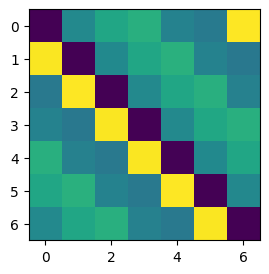

In [8]:
plt.figure(figsize=(3,3))
linear.reset_parameters()
weight_P = linear(x, batch_size=batch_size_forward, return_weight=True).detach().cpu().numpy()
print(weight_P  )
plt.imshow( weight_P)
plt.show()

In [9]:
((out_a_prime - out_b_prime)**2).mean()

tensor(1.1223e-06)